# Лабораторная работа №4
# Линейные модели, SVM и деревья решений.

Выполнил: **Пакало А. С., РТ5-61Б**

## Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
1. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
1. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
1. Обучите следующие модели:
  - одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации);
  - SVM;
  - дерево решений.
1. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
1. Постройте график, показывающий важность признаков в дереве решений.
1. Визуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

## Текстовое описание набора данных
Для обучения моделей был выбран набор данных по недельным продажам в сети
магазинов Walmart ([Walmart Dataset](https://www.kaggle.com/datasets/yasserh/walmart-dataset)). На основе данного датасета будем решать задачу регресии.

В данном наборе данных присутствуют следующие столбцы:

* Store — номер магазина;
* Date — дата начала недели продаж;
* Weekly_Sales — недельные продажи магазина. Является целевым признаком;
* Holiday_Flag — бинарный признак отсутствия/наличния (0/1) праздника;
* Temperature — температура в день продаж;
* Fuel_Price — цена топлива в регионе;
* [CPI](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%BF%D0%BE%D1%82%D1%80%D0%B5%D0%B1%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D1%85_%D1%86%D0%B5%D0%BD) — индекс потребительских цен;
* Unemployment — показатель безработицы.

Так как данных очень много, перед тем как приступить к анализу, проведем обзор данных и, возможно, потребуется их предобработка, чтобы датасет стал более удобным и пригодным к проведению исследования.

Таким образом исследование пройдет в 6 этапов:
- загрузка данных,
- проведение разведочного анализа данных и предобработка данных,
- разделение на обучающую и тестовую выборку,
- выбор метрики,
- обучение моделей,
- сравнение значений метрики.

## Импортирование необходимых библиотек, подготовка окружения

In [36]:
# Основные библиотеки.
from IPython.core.display import display_markdown
import numpy as np
import pandas as pd

# Визуализция.
import matplotlib.pyplot as plt
import seaborn as sns

# Для разбития выборки.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Отрисовка статуса выполнения.
from tqdm.notebook import tqdm

# Типизация.
from typing import List

# Вывод данных.
from IPython.display import display


# Конфигурация визуализации.
%matplotlib inline
sns.set(style='ticks')

## Загрузка данных
### Считываем данные из .csv
Загрузим файлы датасета в помощью библиотеки Pandas.

Не смотря на то, что файлы имеют расширение txt они представляют собой данные
в формате [CSV](https://ru.wikipedia.org/wiki/CSV). Часто в файлах такого
формата в качестве разделителей используются символы ",", ";" или табуляция.
Поэтому вызывая метод read_csv всегда стоит явно указывать разделитель данных
с помощью параметра sep. Чтобы узнать какой разделитель используется в файле
его рекомендуется предварительно посмотреть в любом текстовом редакторе.

In [37]:
walmart = pd.read_csv('data/Walmart.csv')

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и предобработка данных.

Размеры датасета: (строки, колонки).

In [38]:
walmart.shape

(6435, 8)

Общий вид данных таблицы:

In [39]:
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Список колонок:

In [40]:
walmart.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

Список колонок с типами данных:

In [41]:
walmart.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

Как видно, все данные приведены к адекватному типу данных.

Пустые значения:

In [42]:
walmart.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Пустых значений нет.

Проверим на дублирующиеся значения:

In [43]:
walmart.duplicated().sum()

0

Дублирующихся значений нет.

## Предобработка данных
С признаком, хранящий дату, будет легче работать, если разбить его на три
отдельные признака: неделя, месяц и год. Можем позволить оставить наименьшей
единицей неделю, так как нам даны лишь *недельные* продажи магазина.

In [44]:
# Разделение поля Date
walmart['Date'] = pd.to_datetime(walmart['Date'], dayfirst=True)
walmart['Week'] = walmart['Date'].dt.isocalendar().week.astype('int64')
walmart['Month'] = walmart['Date'].dt.month
walmart['Year'] = walmart['Date'].dt.year

# Удаление столбца Date
walmart = walmart.drop(columns=['Date'])

# Перестановка столбцов
walmart = walmart[['Store', 'Week', 'Month', 'Year', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']]
display(walmart.head(), walmart.dtypes)



,Store,Week,Month,Year,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,5,2,2010,0,42.31,2.572,211.096358,8.106,1643690.90
1,1,6,2,2010,1,38.51,2.548,211.242170,8.106,1641957.44
2,1,7,2,2010,0,39.93,2.514,211.289143,8.106,1611968.17
3,1,8,2,2010,0,46.63,2.561,211.319643,8.106,1409727.59
4,1,9,3,2010,0,46.50,2.625,211.350143,8.106,1554806.68


Store             int64
Week              int64
Month             int64
Year              int64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Weekly_Sales    float64
dtype: object

## Корреляционный анализ
Построим корреляционную матрицу, чтобы проанализировать зависимости
параметров.
Тепловая карта корреляционной матрицы.

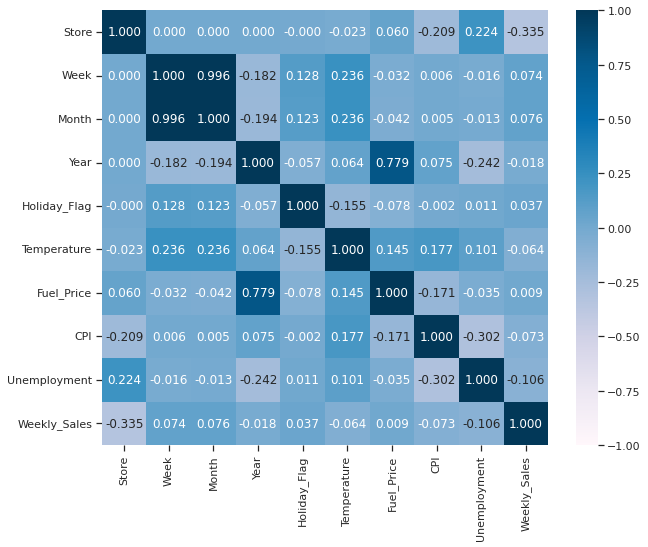

In [45]:
plt.figure(figsize=(10,8))
sns.heatmap(data=walmart.corr(), vmin=-1, vmax=1, annot=True, fmt='.3f',
            cmap='PuBu')
plt.show()

Из данной корреляционной матрицы можем сделать следующие выводы:

- Все нецелевые признаки имеют слабую связь с целевым (Weekly_Sales). Сильнее
всего коррилиует признак Store;
- Признаки Week и Month практически линейно зависимы друг от друга. Оставим
только признак Week;
- Признаки Year и Fuel_Price тоже сильно коррелируют друг с другом. Оставим
признак Fuel_Price.

In [46]:
# Удаление лишних колонок.
walmart_without_linear_correlates = walmart.drop(columns=['Month', 'Year'])
walmart_without_linear_correlates.head()

,Store,Week,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,5,0,42.31,2.572,211.096358,8.106,1643690.90
1,1,6,1,38.51,2.548,211.242170,8.106,1641957.44
2,1,7,0,39.93,2.514,211.289143,8.106,1611968.17
3,1,8,0,46.63,2.561,211.319643,8.106,1409727.59
4,1,9,0,46.50,2.625,211.350143,8.106,1554806.68


In [47]:
# Так как SVM модель чувствительна к выбросам построим графики ящиков с усами.

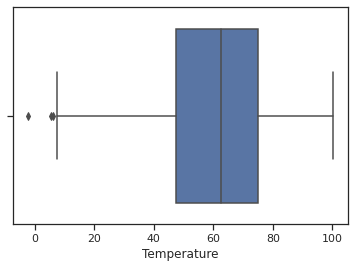

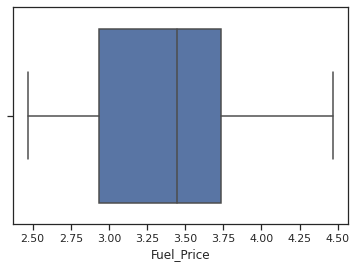

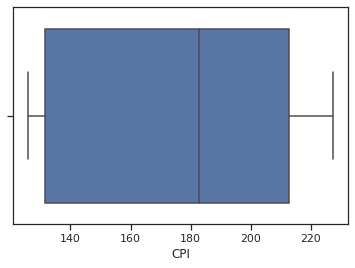

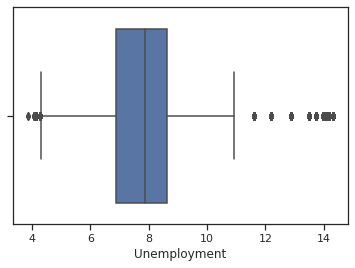

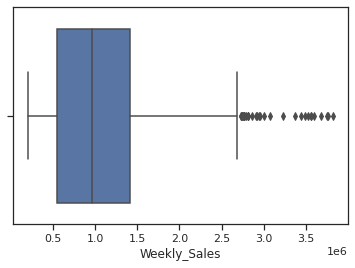

In [48]:
# Ящик с усами для столбца Temperature.

# Не заносим бинарные признаки и даты.
PURELY_NUMERICAL_COL_NAMES = (
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'Weekly_Sales',
)

for col_name in PURELY_NUMERICAL_COL_NAMES:
    sns.boxplot(x=walmart_without_linear_correlates[col_name])
    plt.show()

Наблюдаем большое количество выбросов в колонках с признаками 'Temperature',
'Unemployment' и 'Weekly_Sales'.

## Очистка выбросов.

In [49]:
# Очистка столбца Temperature.
Q1, Q3 = walmart['Temperature'].quantile([0.25, 0.75])
IQR = Q3 - Q1
min_limit = Q1 - 1.5*IQR
max_limit = Q3 + 1.5*IQR

walmart_without_outliers = walmart_without_linear_correlates[
    (walmart_without_linear_correlates['Temperature']
    > min_limit) & (walmart_without_linear_correlates['Temperature'] < max_limit)
]
walmart_without_outliers.shape

(6432, 8)

In [50]:
# Очистка столбца Unemployment.
Q1, Q3 = walmart['Unemployment'].quantile([0.25, 0.75])
IQR = Q3 - Q1
min_limit = Q1 - 1.3*IQR
max_limit = Q3 + 1.3*IQR

walmart_without_outliers = walmart_without_outliers[(walmart_without_outliers['Unemployment'] > min_limit)
                                              & (walmart_without_outliers['Unemployment'] < max_limit)]
walmart_without_outliers.shape

(5832, 8)

In [51]:
# Очистка столбца Weekly_Sales.
Q1, Q3 = walmart['Weekly_Sales'].quantile([0.25, 0.75])
IQR = Q3 - Q1
min_limit = Q1 - 1.5*IQR
max_limit = Q3 + 1.5*IQR

walmart_without_outliers = walmart_without_outliers[(walmart_without_outliers['Weekly_Sales'] > min_limit)
                                              & (walmart_without_outliers['Weekly_Sales'] < max_limit)]
walmart_without_outliers.shape

(5798, 8)

Посмотрим на результат очистки:

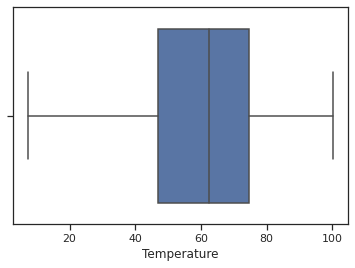

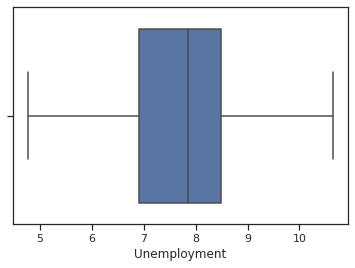

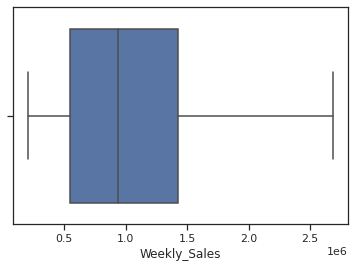

In [52]:
# Ящик с усами для столбца Temperature.
sns.boxplot(x=walmart_without_outliers['Temperature'])
plt.show()
# Ящик с усами для столбца Unemployment.
sns.boxplot(x=walmart_without_outliers['Unemployment'])
plt.show()
# Ящик с усами для столбца Weekly_Sales.
sns.boxplot(x=walmart_without_outliers['Weekly_Sales'])
plt.show()

## Масштабирование
Нам также потребуется масштабировать данные для адекватной работы моделей (и
линейные , и SVM работают лучше, если  признаки представлены в одном
масштабе).

In [53]:
preprocessor = Pipeline([
    ( 'scaler', MinMaxScaler(feature_range=(0, 1)) )
])


walmart_transformed = preprocessor.fit_transform(walmart_without_outliers)
# Массив переводим обратно в датафрейм.
walmart_transformed = pd.DataFrame(walmart_transformed,
                                            columns=walmart_without_outliers.columns)
walmart_transformed

,Store,Week,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,0.0,0.078431,0.0,0.376025,0.050100,0.840500,0.567406,0.579189
1,0.0,0.098039,1.0,0.335024,0.038076,0.841941,0.567406,0.578489
2,0.0,0.117647,0.0,0.350345,0.021042,0.842405,0.567406,0.566374
3,0.0,0.137255,0.0,0.422637,0.044589,0.842707,0.567406,0.484672
4,0.0,0.156863,0.0,0.421234,0.076653,0.843008,0.567406,0.543282
...,...,...,...,...,...,...,...,...
5793,1.0,0.745098,0.0,0.619551,0.764028,0.651876,0.666041,0.203278
5794,1.0,0.764706,0.0,0.619659,0.758016,0.653427,0.663140,0.211471
5795,1.0,0.784314,0.0,0.507229,0.765531,0.654977,0.663140,0.211879
5796,1.0,0.803922,0.0,0.528809,0.750000,0.655013,0.663140,0.205278


In [54]:
# Извлекаем целевой признак.
TARGET_COL_NAMES = ['Weekly_Sales']
walmart_weekly_sales = walmart_transformed[TARGET_COL_NAMES]

walmart_features = walmart_transformed.drop(columns=TARGET_COL_NAMES)
display(walmart_features, walmart_weekly_sales)

,Store,Week,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,0.0,0.078431,0.0,0.376025,0.050100,0.840500,0.567406
1,0.0,0.098039,1.0,0.335024,0.038076,0.841941,0.567406
2,0.0,0.117647,0.0,0.350345,0.021042,0.842405,0.567406
3,0.0,0.137255,0.0,0.422637,0.044589,0.842707,0.567406
4,0.0,0.156863,0.0,0.421234,0.076653,0.843008,0.567406
...,...,...,...,...,...,...,...
5793,1.0,0.745098,0.0,0.619551,0.764028,0.651876,0.666041
5794,1.0,0.764706,0.0,0.619659,0.758016,0.653427,0.663140
5795,1.0,0.784314,0.0,0.507229,0.765531,0.654977,0.663140
5796,1.0,0.803922,0.0,0.528809,0.750000,0.655013,0.663140


,Weekly_Sales
0,0.579189
1,0.578489
2,0.566374
3,0.484672
4,0.543282
...,...
5793,0.203278
5794,0.211471
5795,0.211879
5796,0.205278


## С использованием метода train_test_split разделите выборку на обучающую и тестовую.

In [55]:

walmart_features_train: pd.DataFrame
walmart_features_test: pd.DataFrame
walmart_weekly_sales_train: pd.Series
walmart_weekly_sales_test: pd.Series

# Параметр random_state позволяет задавать базовое значение для генератора
# случайных чисел. Это делает разбиение неслучайным. Если задается параметр
# random_state то результаты разбиения будут одинаковыми при различных
# запусках. На практике этот параметр удобно использовать для создания
# "устойчивых" учебных примеров, которые выдают одинаковый результат при
# различных запусках.
RANDOM_STATE_SEED = 1

walmart_features_train, walmart_features_test, walmart_weekly_sales_train, walmart_weekly_sales_test = train_test_split(
    walmart_features, walmart_weekly_sales, random_state=RANDOM_STATE_SEED)

Общий вид обучающей выборки:

In [56]:
from typing import Union
def display_df_shape(df: Union[pd.DataFrame, pd.Series]):
    display_markdown(
        f'- Кол-во рядов: {df.shape[0]}\n- Кол-во колонок: {df.shape[1]}',
        raw=True)


def display_split_result(split: Union[pd.DataFrame, pd.Series]):
    """Display result of the train_test_split.

    :param split: one of the splits to display.
    :type split: pd.DataFrame, pd.Series
    """

    display(split.head(1))
    display_df_shape(split)
    
    
display_split_result(walmart_features_train)
display_split_result(walmart_weekly_sales_train)

,Store,Week,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
3057,0.522727,0.117647,0.0,0.286793,0.47495,0.072217,0.592321


- Кол-во рядов: 4348
- Кол-во колонок: 7

,Weekly_Sales
3057,0.464644


- Кол-во рядов: 4348
- Кол-во колонок: 1

Общий вид тестовой выборки:

In [57]:
display_split_result(walmart_features_test)
display_split_result(walmart_weekly_sales_test)

,Store,Week,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1822,0.318182,0.607843,0.0,0.698209,0.225952,0.064901,0.566212


- Кол-во рядов: 1450
- Кол-во колонок: 7

,Weekly_Sales
1822,0.166622


- Кол-во рядов: 1450
- Кол-во колонок: 1

## Выбор метрики
Для измерения качества моделей, решающих задачу линейной регрессии, будем
использовать следующие метрики:
- Средняя абсолютная ошибка (MAE),
- Средняя квадратичная ошибка (MSE),
- Коэффициент детерминации (R2).

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

scoring = (
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'r2',
)

def score(data_predicted, data_test):
    mae = mean_absolute_error(data_predicted, data_test)
    mse = mean_squared_error(data_predicted, data_test)
    r2 = r2_score(data_predicted, data_test)

    return {
        'mae': mae,
        'mse': mse,
        'r2': r2
    }


def display_score(scores):
    mae = scores.get('mae') or '---'
    mse = scores.get('mse') or '---'
    r2 = scores.get('r2') or '---'

    display_markdown(f'''
- Средняя абсолютная ошибка: {mae};
- Средняя квадратичная ошибка: {mse};
- Коэффициент детерминации: {r2}.
    ''', raw=True)

In [59]:
# Метрики будем складывать в этот словарь для дальнейшего сравнительного
#   анализа.
metrics_data = {}

def add_metrics_data(model_name, model_metric_data):
    metrics_data[model_name] = {}

    for metric_name, score in model_metric_data.items():
        metrics_data[model_name][metric_name] = score

# Обучение на основе моделей
## 1.1 Линейная регрессия

In [60]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

linear_regression = LinearRegression()

linear_regression_pipeline = Pipeline([
    ( 'preprocess', preprocessor ),
    ( 'model', linear_regression ),
])

walmart_weekly_sales_predicted = linear_regression_pipeline.fit(walmart_features_train,
                   walmart_weekly_sales_train).predict(walmart_features_test)
linear_regression_score = score(walmart_weekly_sales_predicted, walmart_weekly_sales_test)
add_metrics_data('LinearRegression', linear_regression_score)
display_score(linear_regression_score)


- Средняя абсолютная ошибка: 0.17111329821089571;
- Средняя квадратичная ошибка: 0.04211770011419011;
- Коэффициент детерминации: -6.220291257818771.
    

CPU times: user 13.9 ms, sys: 7.15 ms, total: 21 ms
Wall time: 8.96 ms


## 1.2 Полиномиальная регрессия
У нелинейной регрессии есть гиперпараметр degree, обозначающий степень
полинома. Его подберём с помощью RandomizedSearchCV.

In [61]:
import re
def add_metrics_data_from_search_results(results, model='LinearRegression'):
    metrics_data[model] = {}

    # Negative errors are used for scoring, we have to handle them manually.
    metrics_data[model]['mae'] = max([abs(v) for v in
                                         results['mean_test_neg_mean_absolute_error']])
    metrics_data[model]['mse'] = max([abs(v) for v in
                                         results['mean_test_neg_mean_squared_error']])

    # Everything else is parseble (in our case only 'r2').
    for result, value in results.items():
        if result in ('mean_test_neg_mean_absolute_error',
                      'mean_test_neg_mean_squared_error'):
            continue

        metric_match = re.match(r'mean_test_(.+)', result)
        if metric_match:
            metric_name = metric_match.group(1)
            metrics_data[model][metric_name] = max(value)

In [62]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

linear_regression = LinearRegression()
polynomial_features = PolynomialFeatures()

polynomial_regression_estimator = Pipeline([
    ( 'preprocess', preprocessor ),
    ( 'poly_features', polynomial_features ),
    ( 'model', linear_regression ),
])

parameters_to_tune = { 'poly_features__degree': np.arange(1, 6, 1) }

polynomial_regression_pipeline = RandomizedSearchCV(polynomial_regression_estimator,
                                                    parameters_to_tune,
                                                    n_iter=5,
                                                    scoring=scoring,
                                                    cv=KFold(n_splits=3),
                                                    refit=scoring[2]
                                                    )

polynomial_regression_pipeline.fit(walmart_features_train,
                   walmart_weekly_sales_train)

add_metrics_data_from_search_results(polynomial_regression_pipeline.cv_results_,
                                     model='PolynomialRegression')

display(polynomial_regression_pipeline.best_score_,
        polynomial_regression_pipeline.best_params_)

0.520211730678377

{'poly_features__degree': 4}

CPU times: user 11.6 s, sys: 7.77 s, total: 19.4 s
Wall time: 5.19 s


## 2 Метод опорных векторов (SVM)
У линейной регресси на опорных векторах есть гиперпараметр C,
обозначающий силу регуляризации. Его подберём также с помощью
RandomizedSearchCV.

In [63]:
%%time
from sklearn.svm import LinearSVR

# Параметр регуляризации должен быть строго положителен.
parameters_to_tune = { 'model__C': np.logspace(1e-5, 1, num=10) }

linear_svr = LinearSVR(max_iter=10_000)

linear_svr_estimator = Pipeline([
    ( 'preprocess', preprocessor ),
    ( 'model', linear_svr ),
])

linear_svr_pipeline = RandomizedSearchCV(linear_svr_estimator,
                                         parameters_to_tune,
                                         scoring=scoring,
                                         refit=scoring[2]
                                        )
linear_svr_pipeline.fit(walmart_features_train,
               walmart_weekly_sales_train.values.ravel()).predict(walmart_features_test)
add_metrics_data_from_search_results(linear_svr_pipeline.cv_results_,
                                     model='LinearSVR')
display(linear_svr_pipeline.best_score_,
        linear_svr_pipeline.best_params_)

/home/dubuntus/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dubuntus/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dubuntus/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dubuntus/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dubuntus/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.07454239226587685

{'model__C': 5.994873178012294}

CPU times: user 3.15 s, sys: 90.7 ms, total: 3.24 s
Wall time: 3.1 s


## 3 Дерево решений

Деревья нечувствительны к математическому ожиданию признаков, поэтому
попробуем провести исследование на неотмасштабированных данных.
Разделим неотмасштабированные данные на обучающую и тестовую выборки:

In [64]:
walmart_weekly_sales = walmart_without_outliers[TARGET_COL_NAMES]

walmart_features = walmart_without_outliers.drop(columns=TARGET_COL_NAMES)

walmart_features_train: pd.DataFrame
walmart_features_test: pd.DataFrame
walmart_weekly_sales_train: pd.Series
walmart_weekly_sales_test: pd.Series

# Параметр random_state позволяет задавать базовое значение для генератора
# случайных чисел. Это делает разбиение неслучайным. Если задается параметр
# random_state то результаты разбиения будут одинаковыми при различных
# запусках. На практике этот параметр удобно использовать для создания
# "устойчивых" учебных примеров, которые выдают одинаковый результат при
# различных запусках.
RANDOM_STATE_SEED = 1

walmart_features_train, walmart_features_test, walmart_weekly_sales_train, walmart_weekly_sales_test = train_test_split(
    walmart_features, walmart_weekly_sales, random_state=RANDOM_STATE_SEED)

In [65]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'model__max_depth' : [3, 4, 5, 6, 7, 8],
                      'model__min_samples_leaf' : np.linspace(0.01, 0.1, 10),
                      'model__max_features' : [0.2 , 0.4, 0.6, 0.8, 'auto', 'sqrt', 'log2']}

In [66]:
%%time
from sklearn.tree import DecisionTreeRegressor

decision_tree_regressor = DecisionTreeRegressor(criterion='absolute_error',
                                                random_state=RANDOM_STATE_SEED)

decision_tree_regressor_estimator = Pipeline([
    ( 'preprocess', preprocessor ),
    ( 'model', decision_tree_regressor ),
])

# Оптимизация гиперпараметров
decision_tree_regressor_pipeline = RandomizedSearchCV(
                                         decision_tree_regressor_estimator,
                                         parameters_to_tune,
                                         cv=5,
                                         scoring=scoring,
                                         refit=scoring[0]
                                        )

decision_tree_regressor_pipeline.fit(walmart_features_train,
               walmart_weekly_sales_train.values.ravel()).predict(walmart_features_test)
add_metrics_data_from_search_results(decision_tree_regressor_pipeline.cv_results_,
                                     model='DecisionTreeRegressor')
display(abs(decision_tree_regressor_pipeline.best_score_),
        decision_tree_regressor_pipeline.best_params_)

338436.8251839305

{'model__min_samples_leaf': 0.05000000000000001,
 'model__max_features': 0.8,
 'model__max_depth': 5}

CPU times: user 8.25 s, sys: 0 ns, total: 8.25 s
Wall time: 8.25 s


Генерация графа дерева с помощью библиотеки graphviz.

In [67]:
from sklearn.tree import export_graphviz
import graphviz

# Выбираем наше дерево из конвейера.
best_decision_tree_estimator = decision_tree_regressor_pipeline.best_estimator_
best_decision_tree_regressor = best_decision_tree_estimator.fit(walmart_features_train,
                                 walmart_weekly_sales_train
                                ).named_steps['model']

In [78]:
dot_data = export_graphviz(best_decision_tree_regressor,
                           feature_names=list(walmart_features_train.columns),
                           filled=True, rounded=True, special_characters=True,
                           rotate=False)

graph = graphviz.Source(dot_data, format='svg', directory='images', filename='graph', engine='dot')
graph.render()

'images/graph.svg'

In [82]:
# Визуализация дерева с помощью графа
from IPython.core.display import HTML
HTML('<img src="images/graph.svg" width=100%>')

## Сравните метрики качества исходной и оптимальной моделей

In [76]:
from typing import Dict

def grouped_bar_chart(ax, data: Dict[str, List[float]],
                      tick_labels, colors=None, total_width=0.8,
             single_width=1):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax: matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: Dict[str, List[float]]
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[ 1, 2,      3      ],
            "y":[ 1, np.nan, 3      ],
            "z":[ 1, 2,      np.nan ],
        }

    tick_labels: list
        Labels which will be displayed under each group.

        Example:
        tick_labels = ['Accuracy', 'F1', 'Precision']

        Note:
        Length should be the same as number of groups.
        

    colors: array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width: float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


    # Number of bars per group.
    n_bars = len(data)

    # The width of a single bar.
    bar_width = total_width / n_bars

    tick_locations = np.arange(len(tick_labels))

    # Iterate over all data.
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar.
        tick_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # One bar plot consists of multiple rectangles.
        rects = ax.bar(tick_locations + tick_offset, values, width=bar_width * single_width,
                     color=colors[i % len(colors)],
                     label=name)
        # Add a handle to the last drawn bar, which we'll need for the legend.
        # bars.append(bars[0])

        ax.bar_label(rects, padding=3)

    ax.set_xticks(tick_locations, labels=tick_labels)


def show_metrics_grouped_bar_chart(metrics_data: Dict[str, Dict[str, float]]):
    """ Creates grouped bar chart for metrics.
    :param metrics_data: a dictionary of metrics and their values for each
        model.
    :type metrics_data: Dict[str, Dict[str, float]]

        Example:

        metrics_data = {
            'GridSearchCV': { 
                'Accuracy': 1,
                'a': 2,
                'b': 3,
            },
            'RandomSearchCV': {
                'Roc': 2,
                'a': 3,
                'b': 4,
            },
        }

    """
    # plt.figure(figsize=(7,3))
    width = 15
    height = 15
    plt.rcParams['figure.figsize'] = width, height

    fig, ax = plt.subplots()

    # Extracting unique metric names from our data.
    tick_labels = set()
    for model_metrics in metrics_data.values():
        tick_labels.update(list(model_metrics.keys()))

    """ Converting our dictionary to a `fully filled` dictionary of lists:
    data = {
        'GridSearchCV': [ 
            1, # was 'Accuracy': 1,
            2, # was 'a': 2,
            3, # was 'b': 3,
            None, # didn't have value for 'Roc';
        ],
        'RandomSearchCV': [
            None, # didn't have value for 'Accuracy',
            3, # was 'a': 3,
            4, # was 'b': 4,
            2, # was 'Roc': 2;
        ],
    }
    """
    filled_metrics_data = {}

    for model in metrics_data.keys():
        filled_metrics_data[model] = []
        for metric in tick_labels:
            filled_metrics_data[model].append(metrics_data[model].get(metric)
                                              or np.nan)
            
    
    grouped_bar_chart(ax, filled_metrics_data, tick_labels=tick_labels,
                      total_width=.8, single_width=.9, colors=['#aadddd',
                          '#eebbbb', '#ccbbbb', '#77bb77'])

    plt.title('Сравнение метрик качества моделей')
    plt.xlabel('Метрика')
    plt.ylabel('Значение метрики')

    ax.legend(title='Стратегия', bbox_to_anchor=(1.2, 1))

    plt.yscale('log')
    plt.show()

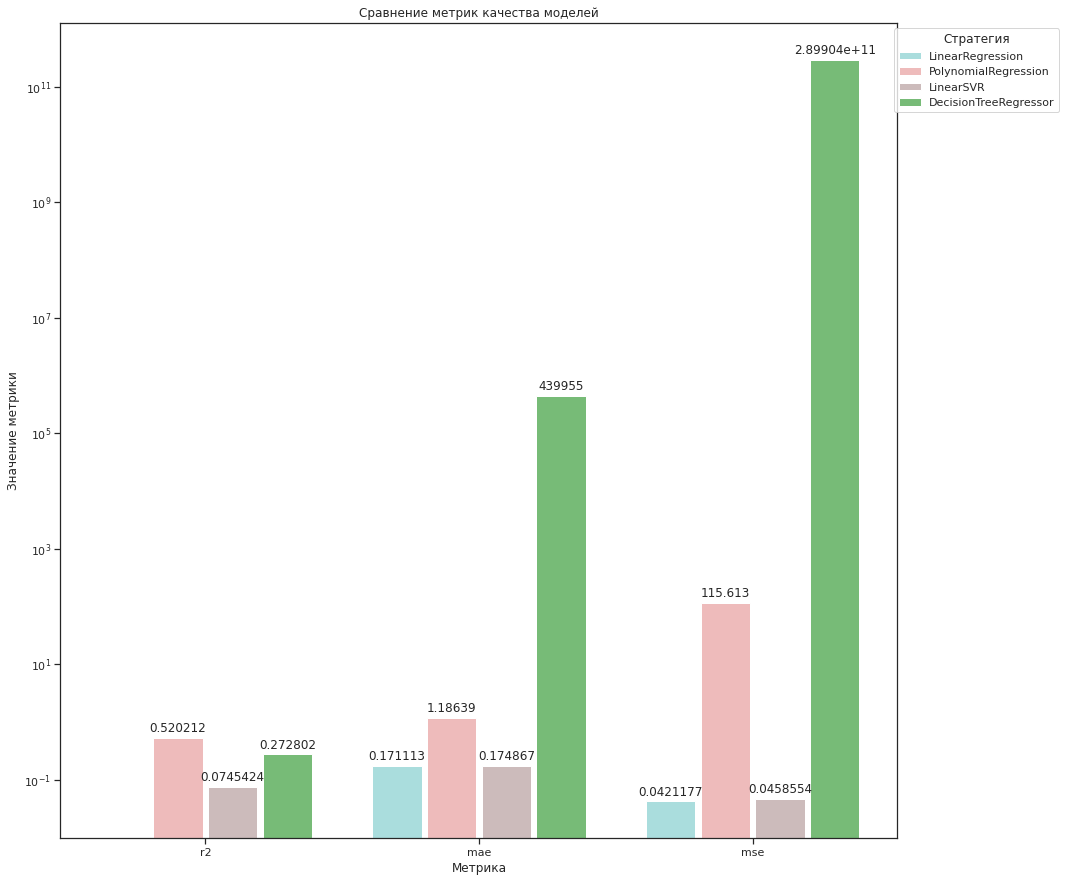

In [77]:
show_metrics_grouped_bar_chart(metrics_data)